# Saliency Map by VL

This method is recreating saliency maps. It is done by an iterative process of removing pixels. (=setting them Black 0,0,0)
By doing this we try to find pixels which greatly impact the result (A threshold can be set). After some pixels are found, pixels are grouped together using logic groups. (circle, rectangle, nearest neighbors)


In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
import numpy as np
import json
import image_operations as iop
import matplotlib.pyplot as plt

### Load ResNet50 and some helper functions

In [2]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()
#display(model)


# Transformer always stays the same
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load imagenet_labels
with open('imagenet_class_index.json') as f:
    imagenet_labels = json.load(f)

imagenet_labels = {int(k):v for k,v in imagenet_labels.items()}


### Load Image and predict. Functions are defined singularly for better understanding and to be able to adapt them later.

In [35]:
def predict(image_tensor):
    output = model(image_tensor)
    output = torch.nn.functional.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    return prediction_score, pred_label_idx, imagenet_labels[pred_label_idx.item()]

# This function exists to adapt the pixels of the image for the saliency map
def load_image(image_path):
    image = Image.open(image_path)
    return image

def image_to_tensor_image(image, plot=False):
    if plot:
        display(image)
    image = transform(image)
    image = image.unsqueeze(0)
    return image

def evaluate_image(image, plot=False, print_result=True):
    image_tensor = image_to_tensor_image(image, plot)
    prediction_score, pred_label_idx, pred_label = predict(image_tensor)
    if print_result:
        print(f"Prediction: {pred_label} ({prediction_score.item()})")
    return prediction_score, pred_label_idx, pred_label

def evaluate_image_from_path(image_path, plot=False):
    image_tensor = image_to_tensor_image(load_image(image_path), plot)
    prediction_score, pred_label_idx, pred_label = predict(image_tensor)

    print(f"Prediction: {pred_label} ({prediction_score.item()})")

In [4]:
evaluate_image_from_path('datasets/imagenet-sample-images-master/n01440764_tench.JPEG')
evaluate_image_from_path('datasets/imagenet-sample-images-master/n01443537_goldfish.JPEG')
evaluate_image_from_path('datasets/imagenet-sample-images-master/n01484850_great_white_shark.JPEG')
evaluate_image_from_path('datasets/imagenet-sample-images-master/n01491361_tiger_shark.JPEG')

Prediction: tench, Tinca tinca (0.43982869386672974)
Prediction: goldfish, Carassius auratus (0.4925224483013153)
Prediction: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias (0.5196487903594971)
Prediction: tiger shark, Galeocerdo cuvieri (0.6748911142349243)


# Blacking out pixels / Removing pixels

The files black_out_pixels takes an image and a pixels to be blacked out. It returns a new image with the blacked out pixels. This is useful to find out if special parts of the picture are important for the prediction. If the prediction changes, the pixels are important. If the prediction stays the same, the pixels are not important.


### We consider the case of the junco because it takes up only a small part of the picture. If we black out the junco, the prediction should change.

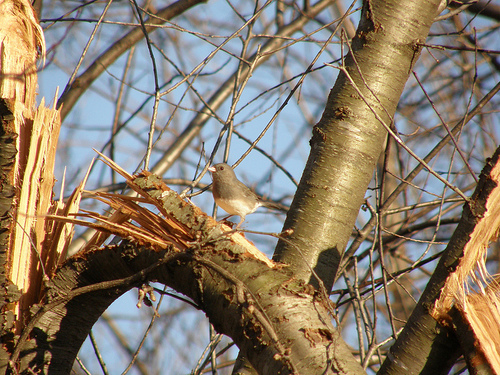

Prediction: junco, snowbird (0.6026009321212769)


In [5]:
# load image junco
evaluate_image_from_path('datasets/imagenet-sample-images-master/n01534433_junco.JPEG', plot=True)


### Blacking out random pixels 0/10

Method: Blacking out a percentage of the pixels
Expected Behaviour: The prediction shouldn't change

Observed Behaviour: The prediction changes to an image with the observed black point pattern. The score is very low, indicating that something is wrong very likely.

In [55]:
def test_method_with_different_seeds(method, arguments, number_of_tests=10):
    for i in range(number_of_tests):
        # generate random integer
        seed = np.random.randint(0, 100000)
        print(f"Test {i}")
        image = method(*arguments, seed=seed)
        image = Image.fromarray(image)
        evaluate_image(image, plot=False)

image = load_image('datasets/imagenet-sample-images-master/n01534433_junco.JPEG')
image = np.asarray(image)

black_out_method = iop.black_out_random_pixels
arguments = (image, 0.2)

test_method_with_different_seeds(black_out_method, arguments, 5)

Test 0
Prediction: coucal (0.09063348919153214)
Test 1
Prediction: coucal (0.07443650811910629)
Test 2
Prediction: bald eagle, American eagle, Haliaeetus leucocephalus (0.09173638373613358)
Test 3
Prediction: bald eagle, American eagle, Haliaeetus leucocephalus (0.1326952874660492)
Test 4
Prediction: coucal (0.07464280724525452)


### Zooming into ares of the picture 4/10

Method: Splitting the area into a grid and zooming into the center of each grid cell. The most correct prediction is chosen as most important area.
Expected Behaviour: The prediction should change to the most important area. For complex images, it might not work.

Observed Behaviour: For clearly distinguishable areas, the prediction changes to the most important area. For complex images, it doesn't work. I am quite happy with the result, as it is quite easy to implement and works quite well.

Improvements: One could create  a better clustering algorithm and weight the results.

Prediction: goldfish, Carassius auratus (0.4925224483013153)


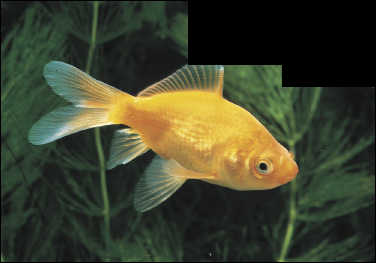

In [56]:
def simple_zoom_saliency(image):
    _, pred_label_idx_real, _= evaluate_image(image, plot=False)
    image = np.asarray(image)

    # iterate over grid, zoom into different grids
    mask = np.zeros(image.shape, dtype=np.uint8)

    for zoomer in [i**2 for i in range(2,7)]:
        images, area_bound = iop.split_image_into_x_areas(image, zoomer)
        predictions = []

        for i,image_ in enumerate(images):
            img_section = Image.fromarray(image_)
            prediction_score, pred_label_idx, _ = evaluate_image(img_section, plot=False, print_result=False)
            # if the prediction is the same as the real prediction, add it to the mask
            if pred_label_idx == pred_label_idx_real:
                # highlight area in mask
                mask[area_bound[i][0]:area_bound[i][1],area_bound[i][2]:area_bound[i][3]] = 1

    # apply mask to image
    image_saliency = image * mask
    image_saliency = Image.fromarray(image_saliency)

    return image_saliency

#display(simple_zoom_saliency(load_image('datasets/imagenet-sample-images-master/n01534433_junco.JPEG')))
#display(simple_zoom_saliency(load_image('datasets/imagenet-sample-images-master/n01440764_tench.JPEG')))
#display(simple_zoom_saliency(load_image('datasets/imagenet-sample-images-master/n01443537_goldfish.JPEG')))

